In [ ]:
pip install syft==0.2.9

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import syft as sy
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# hook PyTorch to PySyft i.e. add extra functionalities to support Federated Learning
# and other private AI tools
hook = sy.TorchHook(torch)
 
# we create two imaginary schools
node1 = sy.VirtualWorker(hook, id="node1")
node2 = sy.VirtualWorker(hook, id="node2")


In [ ]:
df = pd.read_csv("data456.csv")
df.head()

,Applied Loan Amount,Applied Loan Tenor,Loan Purpose,Gender,Age,Marital Status,Education Level,Residential Status,Monthly Housing/Rental,Contract Staff (Y/N),Employment Type,Nature of Business,Job Position,Monthly Income,Office (Area)_1,Office (Area)_2,Office (Area)_3,Office (Area)_6,Indicators
0,60000,24,Car Purchase,M,22.301,Single,Secondary,Live With Relatives,0.0,N,Fixed Income Earner,Sales,Private,10245.0,0,1,0,0,0
1,100000,60,Settle Loan / Credit Card O/S,M,33.159,Single,Form 3 or below,Live With Relatives,0.0,N,Fixed Income Earner,Services,Private,10000.0,1,0,0,0,0
2,50000,24,Personal use,F,28.389,Married,University,Rental,2000.0,N,Fixed Income Earner,Services,Private,9700.0,0,0,1,0,0
3,70000,36,Personal use,M,35.573,Married,Post Graduate,Rental,1200.0,N,Civil Servant,Manager,Government/Semi-Government,23000.0,0,1,0,0,0
4,300000,60,Settle Loan / Credit Card O/S,F,30.849,Single,University,Mortgaged Private Housing,11000.0,N,Fixed Income Earner,Manager,Private,34000.0,1,0,0,0,0


In [ ]:
df = df.dropna()
df = pd.get_dummies(df)
cols = df.columns.tolist()
cols.remove('Indicators')
cols.append('Indicators')
df = df[cols]
df.head() 

,Applied Loan Amount,Applied Loan Tenor,Age,Monthly Housing/Rental,Monthly Income,Office (Area)_1,Office (Area)_2,Office (Area)_3,Office (Area)_6,Loan Purpose_Birth Giving,Loan Purpose_Business,Loan Purpose_Car Purchase,Loan Purpose_Decoration,Loan Purpose_Education,Loan Purpose_Funeral Expenses,Loan Purpose_Investment,Loan Purpose_Marriage,Loan Purpose_Medical Expenses,Loan Purpose_Personal use,Loan Purpose_Settle Loan / Credit Card O/S,Loan Purpose_Stand by,Loan Purpose_Tax Payment,Loan Purpose_Traveling,Gender_F,Gender_M,Marital Status_Divorced,Marital Status_Married,Marital Status_No Response,Marital Status_Separated,Marital Status_Single,Marital Status_Widowed,Education Level_Form 3 or below,Education Level_No Response,Education Level_Post Graduate,Education Level_Post Secondary,Education Level_Primary,Education Level_Secondary,Education Level_University,Residential Status_Company Provision,Residential Status_Live With Relatives,...,Residential Status_Self-owned Private Housing,Residential Status_Self-owned Public Housing,Contract Staff (Y/N)_N,Contract Staff (Y/N)_Y,Employment Type_Civil Servant,Employment Type_Fixed Income Earner,Employment Type_Non Fixed Income Earner,Employment Type_Not Applicable,Employment Type_Self-Employed,Employment Type_Self-Employed Professional,Nature of Business_All Other,Nature of Business_Construction Trades,Nature of Business_Driver,Nature of Business_Executive,Nature of Business_Factory Worker,Nature of Business_Guard,Nature of Business_Homemaker,Nature of Business_Manager,Nature of Business_No Response,Nature of Business_Office Worker,Nature of Business_Owner of a Business,Nature of Business_Professional,Nature of Business_Retired,Nature of Business_Sales,Nature of Business_Semi Professional,Nature of Business_Services,Nature of Business_Skilled Worker,Nature of Business_Student,Nature of Business_Unemployed,Nature of Business_Unskilled Worker,Job Position_Government/Semi-Government,Job Position_Homemaker,Job Position_No Response,Job Position_Private,Job Position_Public,Job Position_Retired,Job Position_Self Employed,Job Position_Student,Job Position_Unemployed,Indicators
0,60000,24,22.301,0.0,10245.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,100000,60,33.159,0.0,10000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,50000,24,28.389,2000.0,9700.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,70000,36,35.573,1200.0,23000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,300000,60,30.849,11000.0,34000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
# df = df.astype(np.float64)
# df["Final_Status (Y/N)"].astype(int)
df.dtypes

Applied Loan Amount             int64
Applied Loan Tenor              int64
Age                           float64
Monthly Housing/Rental        float64
Monthly Income                float64
                               ...   
Job Position_Retired            uint8
Job Position_Self Employed      uint8
Job Position_Student            uint8
Job Position_Unemployed         uint8
Indicators                      int64
Length: 84, dtype: object

In [ ]:
# df['Class_att'] = df['Class_att'].astype('category')
# encode_map = {
#     'Abnormal': 1,
#     'Normal': 0
# }

# df['Class_att'].replace(encode_map, inplace=True)

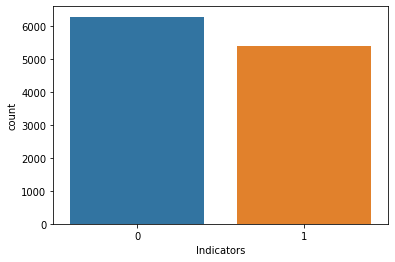

In [ ]:
sns.countplot(x = 'Indicators', data=df)

In [ ]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [ ]:
print(X.shape, y.shape)

(11661, 83) (11661,)


In [ ]:
np.any(np.isnan(y))

False

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
print(X_train.shape, X_test.shape)

(7812, 83) (3849, 83)


In [ ]:
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [ ]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(torch.Tensor(y_train.values)))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [ ]:
train_loader = sy.FederatedDataLoader(train_data.federate((node1, node2)), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1) # may need increase later

In [ ]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(83, 160)
        self.layer_2 = nn.Linear(160, 40)
        self.layer_out = nn.Linear(40, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(160)
        self.batchnorm2 = nn.BatchNorm1d(40)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [ ]:
# check to use GPU or not
use_cuda = True and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
###############

cpu


In [ ]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=83, out_features=160, bias=True)
  (layer_2): Linear(in_features=160, out_features=40, bias=True)
  (layer_out): Linear(in_features=40, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
model.train()
e_loss = []
e_acc = []
timelist = []
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    start_time = time.time()
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        model = model.send(X_batch.location)

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        model.get()

        epoch_loss += loss.get()
        epoch_acc += acc.get()
    total_time = time.time() - start_time
    timelist.append(total_time)
    e_loss.append((epoch_loss/len(train_loader)).item()) # for plt
    e_acc.append((epoch_acc/len(train_loader)).item()) # for plt
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f} | Time: {total_time:.3f}')

Epoch 001: | Loss: 0.70273 | Acc: 55.585 | Time: 12.607
Epoch 002: | Loss: 0.66988 | Acc: 60.114 | Time: 12.760
Epoch 003: | Loss: 0.64173 | Acc: 64.220 | Time: 12.395
Epoch 004: | Loss: 0.62385 | Acc: 67.081 | Time: 12.408
Epoch 005: | Loss: 0.61595 | Acc: 68.301 | Time: 12.460
Epoch 006: | Loss: 0.60258 | Acc: 70.163 | Time: 12.370
Epoch 007: | Loss: 0.59758 | Acc: 70.130 | Time: 12.408
Epoch 008: | Loss: 0.59306 | Acc: 70.846 | Time: 12.403
Epoch 009: | Loss: 0.58862 | Acc: 70.976 | Time: 12.412
Epoch 010: | Loss: 0.59001 | Acc: 71.000 | Time: 12.617
Epoch 011: | Loss: 0.58730 | Acc: 71.398 | Time: 12.377
Epoch 012: | Loss: 0.57980 | Acc: 71.659 | Time: 12.424
Epoch 013: | Loss: 0.57938 | Acc: 71.496 | Time: 12.384
Epoch 014: | Loss: 0.57124 | Acc: 72.236 | Time: 12.495
Epoch 015: | Loss: 0.57445 | Acc: 72.878 | Time: 12.559
Epoch 016: | Loss: 0.57001 | Acc: 72.528 | Time: 12.466
Epoch 017: | Loss: 0.55881 | Acc: 73.472 | Time: 12.678
Epoch 018: | Loss: 0.56955 | Acc: 72.764 | Time:

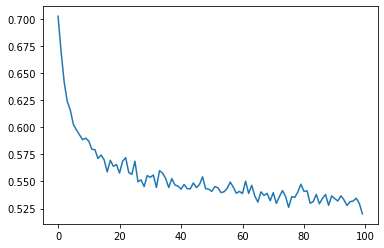

In [ ]:
plt.plot(e_loss)

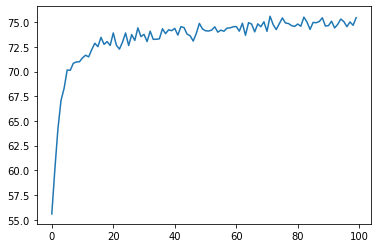

In [ ]:
plt.plot(e_acc)

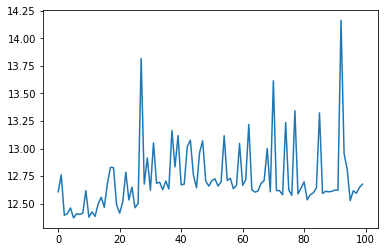

In [ ]:
plt.plot(timelist)

In [ ]:

import statistics
statistics.mean(timelist)

12.726113064289093

In [ ]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
confusion_matrix(y_test, y_pred_list)

array([[1628,  459],
       [ 560, 1202]])

In [ ]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76      2087
           1       0.72      0.68      0.70      1762

    accuracy                           0.74      3849
   macro avg       0.73      0.73      0.73      3849
weighted avg       0.73      0.74      0.73      3849

